# INFO-F-413 - Data Structures and Algorithms - 2021

## Assignment 1: Karger's Algorithm

### Name: Hoang Hai Nam
### M. No.: 443146

Python version used and tested : 3.8.12

Imported libraries: timeit, matplotlib, networkx, time, timeit, math


# 1. Imports & Libraries

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rd
import math as mt
import timeit
import time

# 2. Functions

In [2]:
def plotruntime(f,r,trials=1,figsize=[7,7]):
    Times=[ti.timeit(lambda:f(n),number=trials)/trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r,Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")

    
def plotruntimes(functions,labels,r,trials=5,figsize=[7,7]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[ti.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()


In [3]:
def plotruntime(f, r, trials=1, figsize=[7, 7]):
    Times = [timeit.timeit(lambda: f(n), number=trials) / trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r, Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")


def plotruntimes(functions, labels, r, trials=5, figsize=[7, 7]):
    fig, ax = plt.subplots(figsize=figsize)
    for f, l in zip(functions, labels):
        Times = [timeit.timeit(lambda: f(n), number=trials) / trials for n in r]
        ax.plot(r, Times, label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: " + str(trials) + " trial" + ("s" if trials > 1 else ""))
    ax.legend()


def contracted_edge(G, edge, self_loops=True):
    """Modified contracted_edge() function taken from networkx's source code,
    only value changed was the call to contracted_nodes()
    Changes made so that copy=False as parameter in order to improve runtime,
    no copy graph will be created, the graph G will be directly edited
    The original function creates a new cut graph everytime a node is being contracted,
    going through all the node and edge recreation eats runtime
    """
    u, v = edge[:2]
    if not G.has_edge(u, v):
        raise ValueError(f"Edge {edge} does not exist in graph G; cannot contract it")
    return nx.contracted_nodes(G, u, v, self_loops=self_loops, copy=False)


def contract(g, minnode=2):
    """Algorithm to calculate a minimum cut of a graph
    inputs: a multigraph g, how many nodes left before stopping, default minnode=2
    returns: a contracted multigraph g with minnodes nodes and the number of edges left after the mincut"""
    while g.number_of_nodes() > minnode:
        g = nx.contracted_edge(g, rd.choice(list(g.edges)), self_loops=False)
    return g


def fastcut(g):
    """Recursive fastcut algorithm to calculate a mincut of a graph
    Improves upon Karger's Algorithm in terms of accuracy (sucess probability)
    Inputs: a multigraph g
    Returns: a contracted multigraph g with 2 nodes
    """
    n = g.number_of_nodes()
    if n <= 6:
        return contract(g)
    else:
        t = int(1 + n // mt.sqrt(2))
        h1 = contract(g, minnode=t)
        res1 = fastcut(h1)
        h2 = contract(g, minnode=t)
        res2 = fastcut(h2)
        if res1.number_of_edges() <= res2.number_of_edges():
            return res1
        else:
            return res2


def satgraphgen(n):
    """generates a directed graph with n nodes and saturated number of edges"""
    e = n * (n - 1)
    return nx.MultiGraph(nx.erdos_renyi_graph(n, e))


def fastcuthelper(g, trials=10):
    """Repeats fastcut on a graph for trials number of time"""
    n = g.number_of_nodes()
    res = n * (n - 1)
    for i in range(trials):
        m = fastcut(g)
        if m.number_of_edges() < res:
            res = m.number_of_edges()
    return res


def cutaccbencher(n, e=None, limit=5, Verbose=False):
    """Benchmark the accuracy of Fastcut and Contract given a time limit and nodesize
    Inputs:
    n: nodesize of graphs
    e: edgesize of graphs
    limit: time limit in seconds
    Verbose: wether to print the results or not
    Outputs:
    Tuples of: Accuracy of the 2 functions calculated as sucesses
    """
    # default edge size is a saturated one
    if e is None:
        g = satgraphgen(n)
    else:
        g = nx.MultiGraph(nx.erdos_renyi_graph(n, e))
    # putting faith here that doing 10 trials of fastcut will get to the right answer
    sol = fastcuthelper(g)  # finding the "right" answer
    c = 0
    f = 0
    ctrials = 0
    ftrials = 0
    start = time.time()
    while time.time() - start < limit:
        m = fastcut(g)
        if m.number_of_edges() <= sol:
            f += 1
        ftrials += 1
    start = time.time()
    while time.time() - start < limit:
        m = contract(g)
        if m.number_of_edges() <= sol:
            c += 1
        ctrials += 1
    if Verbose is True:
        print("Fastcut succeeded", f, "out of", ftrials, "trials, a sucess rate of", f * 100 // ftrials, "%",)
        print("Contract succeeded", c, "out of", ctrials, "trials, a sucess rate of", c * 100 // ctrials, "%",)
    return f / ftrials, c / ctrials, ftrials, ctrials


def plotcutprobs(figsize=[7, 7], r=range(3, 15), limit=10):
    """Plots the accuracy of the 2 algorithms"""
    fig, ax = plt.subplots(figsize=figsize)
    frates = []
    crates = []
    for n in r:
        rate = cutaccbencher(n, e=rd.randint(n, n * (n - 1)), limit=limit)
        frates.append(rate[0])
        crates.append(rate[1])
    ax.plot(r, frates, label="FastCut")
    ax.plot(r, crates, label="Contract")
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Sucess rate")
    ax.set_title("Sucess rates of Fastcut and Contract algorithms")
    ax.legend()


def plotcuttrials(figsize=[7, 7], r=range(3, 15), limit=10):
    """Plots the number of trials made within the time limit"""
    fig, ax = plt.subplots(figsize=figsize)
    ftrials = []
    ctrials = []
    for n in r:
        rate = cutaccbencher(n, e=rd.randint(n, n * (n - 1)), limit=limit)
        ftrials.append(rate[2])
        ctrials.append(rate[3])
    ax.plot(r, ftrials, label="FastCut")
    ax.plot(r, ctrials, label="Contract")
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Trials")
    ax.set_title("Trials done by Fastcut and Contract algorithms")
    ax.legend()



# 3. Implementation

In terms of the Contract and Fastcut algorithms, my implementation was as close as possible to the described pseudocode. Each in its basic form are coded as functions contract() and fastcut(). For graph generation and operations, counting nodes, edges and merging them, I used functions found within the networkx package. I also only slightly modified one function within networkx to improve runtime on merging executions.

As for benchmarking the algorithms, the number of nodes are linear, and the number of edges are either saturated (calculated as $n*(n-1)$) or randomised (between $n$ and $n*(n-1)$).

fastcuthelper() is simply a function that reruns the fastcut algorithm for some amount of times, or "trials".

cutaccbencher() is a function that benchmarks the accuracy and to an extent, runtime of Fastcut and Contract, for a given time budget, both algorithms are run as many times as possible and the accuracy/success probability is calculated as success/runs, it returns the accuracy and the number of trials ran by each algorithm. By default each algorithm is allowed to be repeated as many times as possible for 10s, the later functions are used to logging cutaccbencher() at different, incremental node sizes.

The two statistics, accuracy and trials are collected and plotted by the last 2 functions: plotcutprobs() and plotcuttrials().

# 4. Results & Findings

In [8]:
cutaccbencher(20, Verbose=True)

Fastcut succeeded 51 out of 51 trials, a sucess rate of 100 %
Contract succeeded 273 out of 324 trials, a sucess rate of 84 %


(1.0, 0.8425925925925926, 51, 324)

Preliminarily, we can observe that with the same amount of time, Fastcut can repeat much fewer times than Contract, however it is much more accurate.

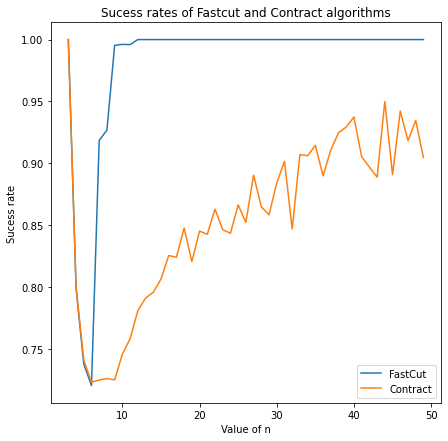

In [4]:
plotcutprobs(figsize=[7, 7], r=range(3, 50), limit=10)
# this call takes 470s to complete as 10*(50-3) is the total time needed within the timelimit

Here, both algorithms are run at different graph node amount, we can observe that Fastcut's accuracy holds 100% accuracy for most of the different sizes. Both algorithms perform the same at n<=6 which validates the functions, as for Fastcut for n<=6, the process is the exact same as Contract. However for both algorithms, we can observe that accuracy dips at around n<=10, and for Contract, slowly rises around n~50. This seems unintuitive, as theoretically, the success probabilities, $\Omega(\frac{2}{n(n-1)})$ for Contract, and $\Omega(\frac{1}{logn})$ for Fastcut, suggest that accuracy falls off as $n \rightarrow \infty$. This is possibly due to the fact that with small values of n, while the graph might still technically be dominated by non-mincut edges, it is less so than with larger values of n, thus the probability of selecting a mincut edge to contract(bad) is quite high for small values of n. Otherwise, as expected, the increased over success probability fits the theory quite well as Fastcut is much more accurate than brute force Contract.

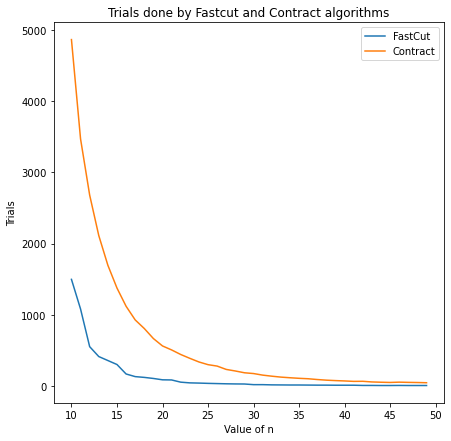

In [10]:
plotcuttrials(figsize=[7, 7], r=range(10, 50), limit=10)
# this call takes 400s to complete as 10*(50-10) is the total time needed within the timelimit

Here we can visualise the difference in runtime by observing the number of times each algorithm can be repeated within a 10-second interval, at different values of n. As expected, Fastcut with a theoretical runtime of $O(n^2logn)$ is worse than Contract in terms of runtime, which is of $O(n^2)$.

# 6. Discussions

## Theorem 1

## The pseudo-code for the fastcut algorithm is as follows:

### FastCut(G):
    n = number of vertices of G
    if n <= 6:
        return: Contract(G)
    else:
        t = 1 + n/sqrt(2)
        H1 = Contract(G,t)
        H2 = Contract(G,t)
        return: minimum_edges(Fastcut(H1), Fastcut(H2))
        



Each recursion step splits 2 independent contractions of $G$ to $t$ vertices, and then 2 more recursions on the resulting graphs. 

$ T(n) = 2 * T_{Contract} + 2 * T_{Recursion} $

As the Contract algorithm's runtime is O(n^2), and t is defined as $1 + \frac{n}{ \sqrt{2}}$ we have the recurrence below:

$ T(n) = 2n^2 + 2T(1 + \frac{n}{ \sqrt{2}}) $

We can solve this recurrence using the **Master theorem**, that has the generic form as follows:

$T(n) = a T(\frac{n}{b}) + f(n)$

We can see that $a = 2$, $b = \sqrt{2}$, $f(n) = 2n^2$

Suspecting that this is case 2 and that $f(n)$ takes the form of $f(n) = O(n^c*log^kn)$ with  $c = 2$ and $k = 0$

We can verify if we satisfy the case 2 condition, in that the work to split the problem is equivalent to the subproblems, in other words: $log_{b}a$ $<=>$ $c$ ?

We have $log_{b}a$ = $log_{ \sqrt{2}}2 = 2$, and $c = 2$. It does indeed satisfies case 2 conditions!

$T(n)$ can then be written as follows: $T(n) = O(n^{log_{b}a}log^{k+1}n) = O(n^{log_{\sqrt{2}}2}log^{0+1}n) = O(n^2logn)$ 

We've succeeded in proving that the runtime of Fastcut can be written as: $O(n^2logn)$ 

## Theorem 2

While it wasn't clear that FastCut's success probabilty is $\Omega(\frac{1}{logn})$, as I previously expected we would see a fall-off of accuracy before running into real-world runtime bottleneck, we can still say with confidence that Fastcut's success probability is much better than that of simple Contract.